In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import numpyro
numpyro.set_host_device_count(8)
import os
#os.environ['PYTENSOR_FLAGS'] = 'floatX=float32'

import sys
from pyprojroot import here
sys.path.append("..") 
from laos_gggi.statistics import get_distance_to_rivers

import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import geopandas as gpd
import xarray as xr

from laos_gggi import load_all_data, load_gpcc_data, load_emdat_data, load_shapefile, load_wb_data
from laos_gggi.data_functions.rivers_data_loader import load_rivers_data
from laos_gggi.data_functions.rivers_damage import create_hydro_rivers_damage, create_floods_rivers_damage
from laos_gggi.replication_data import create_replication_data
from laos_gggi.const_vars import COUNTRIES_ISO, ISO_DICTIONARY, LAOS_LOCATION_DICTIONARY
from laos_gggi.plotting import configure_plot_style, plot_ppc_loopit
from laos_gggi.sample import sample_or_load
from laos_gggi.statistics import get_distance_to_rivers


configure_plot_style()
SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

# Define helper functions

In [3]:
def add_country_effect():
  with pm.modelcontext(None):
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 1)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")
  return country_effect, country_effect_mu, country_effect_scale, country_effect_offset

def add_data(features: list[str], target: str, df: pd.DataFrame, add_time :bool = False):
    with pm.modelcontext(None):
       X = pm.Data("X", df[features], dims = ["obs_idx", "feature"] )
       Y = pm.Data("Y", df[target], dims = ["obs_idx"])
       #time = pm.Data("time", df["time_period"])
    if add_time:
        return X, Y, time
    else:
        return X,Y

In [4]:
# Function to create plot inputs
def generate_plot_inputs(target_variable: str, idata, disaster_type: str = "hydrological_disasters", df = pd.DataFrame ):
    #Extract predictions
    predictions = idata.posterior_predictive['y_hat'].mean(dim=['chain', 'draw'])
    predictions = predictions.to_dataframe().drop(columns = ["year", "ISO"]).reset_index().rename(columns = {"y_hat": "predictions"})

    hdi_mean = az.hdi(idata.posterior_predictive.y_hat)

    hdi = hdi_mean['y_hat'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    hdi_mean_50 = az.hdi(idata.posterior_predictive.y_hat, hdi_prob=.5)
    
    hdi_50 = hdi_mean_50['y_hat'].to_dataframe().drop(columns = ["year", "ISO"]).reset_index()

    #Merge results and predictions in one df
    df_predictions = df[[target_variable, "ISO", "year"]]

    #95% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi.query('hdi == "lower"')[["ISO", "year", "y_hat"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_95"}))
    df_predictions = (pd.merge(df_predictions, hdi.query('hdi == "higher"')[["ISO", "year", "y_hat"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_95"}))
    #50% HDI
    df_predictions = ( pd.merge(df_predictions,  hdi_50.query('hdi == "lower"')[["ISO", "year", "y_hat"]] , 
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "lower_y_hat_50"}))
    df_predictions = (pd.merge(df_predictions, hdi_50.query('hdi == "higher"')[["ISO", "year", "y_hat"]] ,
         left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
                     .rename(columns = {"y_hat": "higher_y_hat_50"}))
    
    #Predictions
    df_predictions = (pd.merge(df_predictions, predictions ,
             left_on= ["ISO", "year"], right_on= ["ISO", "year"], how = "left")
             .rename(columns = {"y_hat": "predictions"}))
    
    return df_predictions

In [5]:
#Plotting function
def plotting_function(idata, country: str, df: pd.DataFrame, target_variable: str):
    df_predictions = generate_plot_inputs(idata = idata, df = df, target_variable = target_variable)

    #Filter country
    data = df_predictions.query("ISO == @country")
    
    fig, ax = plt.subplots()
    ax.plot(data["year"], data["predictions"], zorder=1000, color='tab:red', label=f'Mean Predicted {target_variable}')
    ax.scatter(data["year"], data[target_variable], color='k', label=f'Actual {target_variable}')
    ax.fill_between(data["year"], data["higher_y_hat_95"], data["lower_y_hat_95"], alpha=0.25, color='tab:blue', label='95% HDI')
    ax.fill_between(data["year"], data["lower_y_hat_50"], data["higher_y_hat_50"], alpha=0.5, color='tab:blue', label='50% HDI')
    ax.legend(loc='upper left')

    #plt.title(f"{country} disaster count and predictions")

    plt.xlabel("Year")
    plt.ylabel(F"{target_variable}")
    
    plt.show();
    

In [6]:
def create_grid_from_shape(shapefile, rivers, coastline, grid_size = 100):
    long_min, lat_min, long_max, lat_max = shapefile.dissolve().bounds.values.ravel()
    long_grid = np.linspace(long_min, long_max, grid_size)
    lat_grid = np.linspace(lat_min, lat_max, grid_size)

    grid = np.column_stack([x.ravel() for x in np.meshgrid(long_grid, lat_grid)])
    grid = gpd.GeoSeries(gpd.points_from_xy(*grid.T), crs='EPSG:4326')
    grid = gpd.GeoDataFrame({'geometry': grid})

    point_overlay = grid.overlay(shapefile, how='intersection')
    points = point_overlay.geometry
    points = points.to_frame().assign(long = lambda x: x.geometry.x, lat = lambda x: x.geometry.y)
    
    #Obtain distance with rivers
    distances_to_rivers = (get_distance_to(rivers, points=points, return_columns=['ORD_FLOW', 'HYRIV_ID'])
                           .rename(columns={'distance_to_closest':'distance_to_river'}))

    points = pd.merge(points, distances_to_rivers, left_index= True, right_index= True, how = "left")
    
    #Obtain Laos distance with coastlines
    distances_to_coastlines = (get_distance_to(coastline.boundary, points=points, return_columns=None)
                              .rename(columns={'distance_to_closest':'distance_to_coastline'}))

    points =  pd.merge(points, distances_to_coastlines, left_index= True, right_index= True, how = "left")
    
    #Create log of distances
    points = points.assign(log_distance_to_river = lambda x: np.log(x.distance_to_river),
                           log_distance_to_coastline = lambda x: np.log(x.distance_to_coastline))
    
    if 'ISO_A3' in point_overlay.columns:
        points['ISO'] = point_overlay.ISO_A3
    else:
        points['ISO'] = 'LAO'
        
    return points

In [7]:
from joblib import Parallel, delayed
import pandas as pd
from tqdm.notebook import tqdm

def get_distance_to(gdf, points, return_columns=None, crs="EPSG:3395", n_cores=-1):
    if return_columns is None:
        return_columns = []
        
    gdf_km = gdf.copy().to_crs(crs)
    points_km = points.copy().to_crs(crs)
    
    def get_closest(idx, row, gdf_km, return_columns):
        series = gdf_km.distance(row.geometry)
        index = series[series == series.min()].index[0]

        ret_vals = (series.min(), )
        for col in return_columns:
            ret_vals += (gdf_km.loc[index][col], )
        
        return ret_vals
    
    with Parallel(n_cores, require='sharedmem') as pool:
        results = pool(delayed(get_closest)(idx, row, gdf_km, return_columns) for idx, row in tqdm(points_km.iterrows(), total=points.shape[0]))
    return pd.DataFrame(results, columns = ['distance_to_closest'] + return_columns, index=points.index)

# Importing and cleaning data

In [8]:
rep_df = create_replication_data()
emdat = load_emdat_data()
wb = load_wb_data()

#Load shapefiles
world = load_shapefile('world', repair_ISO_codes=True)
laos = load_shapefile('laos')
coastline = load_shapefile('coastline')
rivers = load_rivers_data()

C:\Users\camil\AppData\Local\Temp\ipykernel_47864\2104074037.py:9: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  rivers = load_rivers_data()


In [9]:
world = load_shapefile('world')
laos = load_shapefile('laos')


In [10]:
damage_df = create_hydro_rivers_damage()

emdat_iso = damage_df.ISO.unique()
world_iso = world.ISO_A3.unique()
wb_iso = wb.index.get_level_values(0).unique()

# Codes in shapefile but not in EMDAT
common_codes = set(world_iso).intersection(set(emdat_iso)).intersection(set(wb_iso))
damage_df = damage_df.query('ISO in @common_codes').copy()
world = world.query('ISO_A3 in @common_codes').copy()
wb = (wb.reset_index().query('country_code in @common_codes').assign(year = lambda x: pd.to_datetime(x.year, format='%Y')).copy())

damage_df = (pd.merge(damage_df, wb, left_on=['ISO', 'year'], right_on=['country_code', 'year'], how='left')
             .dropna(subset=['population_density', 'gdp_per_cap', 'Population']))


In [11]:
#Load river files
big_rivers = gpd.read_file(here('data/rivers/big_rivers.shp'))

#Load Laos points
laos_points = pd.read_csv("../data/laos_points.csv")

In [12]:
#Floods damages and people_affected
damage_df_f = create_floods_rivers_damage()
merged_df_f = pd.merge(damage_df_f, rep_df, right_on=["ISO", "year"], left_on= ["ISO", "year"], how = "left")

#Create different "ORDFLOW" dummies
merged_df_f["ORD_FLOW_1"] = 0
for i in merged_df_f.index.values:
    if merged_df_f.loc[i, "ORD_FLOW"] == 1:
        merged_df_f.loc[i, "ORD_FLOW_1"] = 1

#Create the variable intrecation between closest river and ORD_FLOW
merged_df_f["closest_river_int_ORD_FLOW_1"] = merged_df_f["closest_river"] * merged_df_f["ORD_FLOW_1"]


#Create log of squared population density
merged_df_f["ln_population_density_squared"] =   (2 *merged_df_f["ln_population_density"])

In [13]:
#import disaster probability geospatial data
merged_df5 = pd.read_csv("../data/HSGP_model_data.csv")

C:\Users\camil\AppData\Local\Temp\ipykernel_47864\3973871131.py:2: DtypeWarning: Columns (4,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,36,39,57,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df5 = pd.read_csv("../data/HSGP_model_data.csv")


# Base models

## Base damage model

In [14]:
#df for modeling

rep_df["log_damage_adjusted_hydro"] = np.log(rep_df["Total_Damage_Adjusted_hydro"].replace({0.0: np.nan}))
rep_df["ln_population_density_squared"] = (2 *rep_df["ln_population_density"])




df_2 = rep_df[["ln_population_density", "ln_population_density_squared",  "population",  "ISO",
                  "year" , "log_damage_adjusted_hydro", "ln_gdp_pc", "square_ln_gdp_p",
                 "precip_deviation", "co2"]].dropna()

X_2 = (df_2.drop(columns = ["ISO", "year"]) .astype(int))

#Set coords
ISO_2_idx, ISO_2 =  pd.factorize(df_2["ISO"])
coords = {
    'ISO':ISO_2,
    'year':df_2["year"].unique(),
    'obs_idx':df_2.index,
    'feature': X_2.drop(columns = ["log_damage_adjusted_hydro"]).columns
        }    

xr_idx = xr.Coordinates.from_pandas_multiindex(df_2.set_index(['ISO', 'year']).index, 'obs_idx')

In [15]:
#Store the sample size in the DF
samples_size = pd.DataFrame(columns = ["Sample size"] )
samples_size.loc["base_people_affected_model"] = df_2.shape[0]

In [16]:
#Simple Damages model
with pm.Model(coords=coords) as simple_damages_model:
    #Declare data
    X, Y= add_data(features= coords["feature"] ,  target = "log_damage_adjusted_hydro", df = X_2 )
    X_stand = (X -X.mean())/ X.std()
    
    #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    #beta_sigma = np.ones(8)
    betas = pm.Normal("beta", mu = 0, sigma = 1, dims = ["feature"])

    #Model mu
    mu = pm.math.exp(country_effect[ISO_2_idx] + X_stand @ betas)

    #Sigma
    sigma = pm.Exponential('sigma', lam=1)

    y_hat = pm.Normal("y_hat", observed= Y, mu = mu, sigma = sigma , dims = ["obs_idx"])

In [17]:
#Sampling
with simple_damages_model:
    simple_damages_idata =sample_or_load(
            fp="simple_damages_model2",
            resample= False,
            sample_kwargs={
                "nuts_sampler": 'nutpie',
                "chains": 8,
                "target_accept": 0.9,
                "draws": 1000,
            })

    simple_damages_idata = simple_damages_idata.assign_coords(xr_idx)

In [18]:
az.summary(simple_damages_idata, ["~country_effect", "~country_effect_offset"])

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[ln_population_density],-1.753,0.812,-3.292,-0.290,0.074,0.052,122.0,324.0,1.05
beta[ln_population_density_squared],-1.573,0.704,-2.834,-0.289,0.061,0.043,138.0,538.0,1.04
beta[population],0.028,0.022,-0.012,0.071,0.001,0.001,308.0,642.0,1.03
beta[ln_gdp_pc],-1.502,0.755,-2.895,-0.118,0.060,0.042,162.0,445.0,1.04
beta[square_ln_gdp_p],0.525,0.285,-0.003,1.067,0.017,0.012,292.0,688.0,1.03
beta[precip_deviation],0.027,0.006,0.016,0.039,0.000,0.000,7613.0,5651.0,1.00
beta[co2],0.037,0.075,-0.107,0.180,0.004,0.003,325.0,574.0,1.03
sigma,2.105,0.049,2.016,2.203,0.001,0.000,6863.0,5700.0,1.00
sigma_log__,0.744,0.023,0.701,0.790,0.000,0.000,6863.0,5700.0,1.00


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


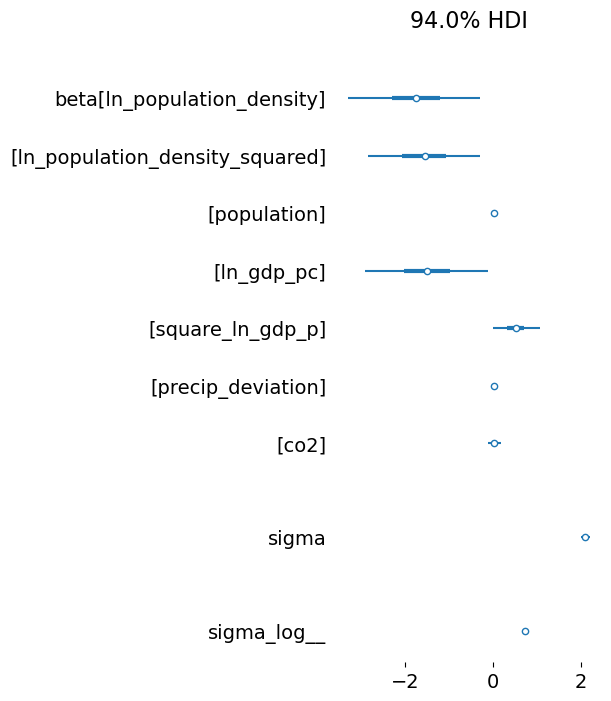

In [19]:
az.plot_forest(simple_damages_idata, var_names = ["~country_effect", "~country_effect_offset"], combined = True);

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\arviz\utils.py:146: UserWarning: Items starting with ~: ['country_effect_offset'] have not been found and will be ignored
  warnings.warn(


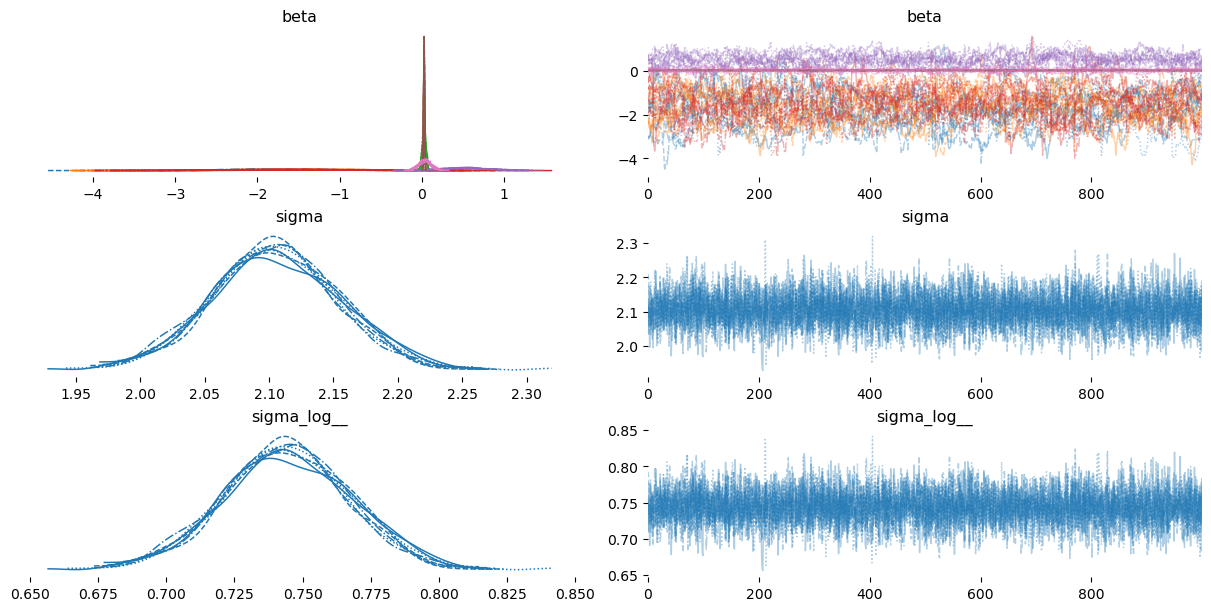

In [20]:
az.plot_trace(simple_damages_idata, var_names =  ["~country_effect", "~country_effect_offset"]);

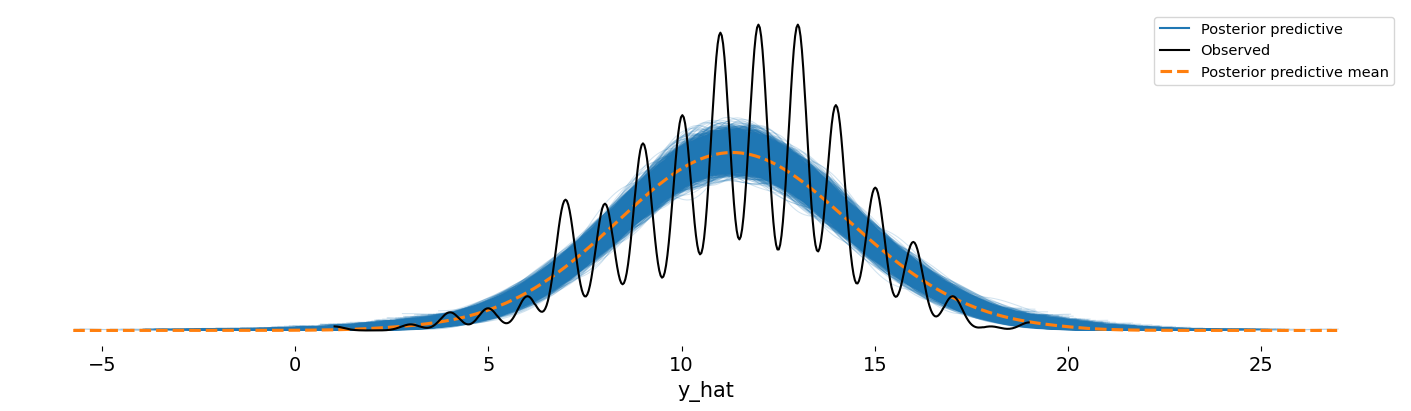

In [21]:
az.plot_ppc(simple_damages_idata);

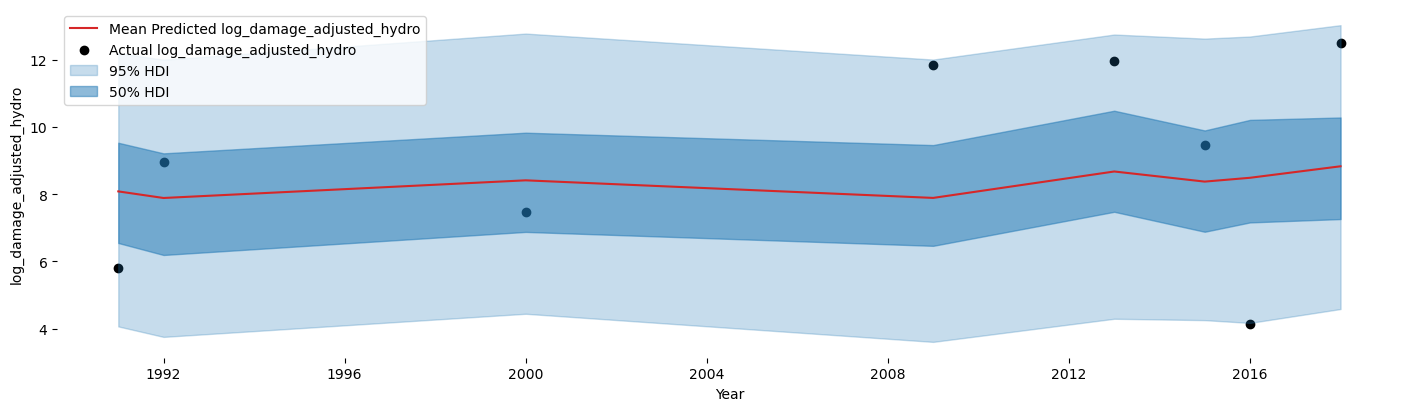

In [22]:
plotting_function(idata =simple_damages_idata , 
                  country = "LAO",
                  df = df_2 ,
                 target_variable= "log_damage_adjusted_hydro")

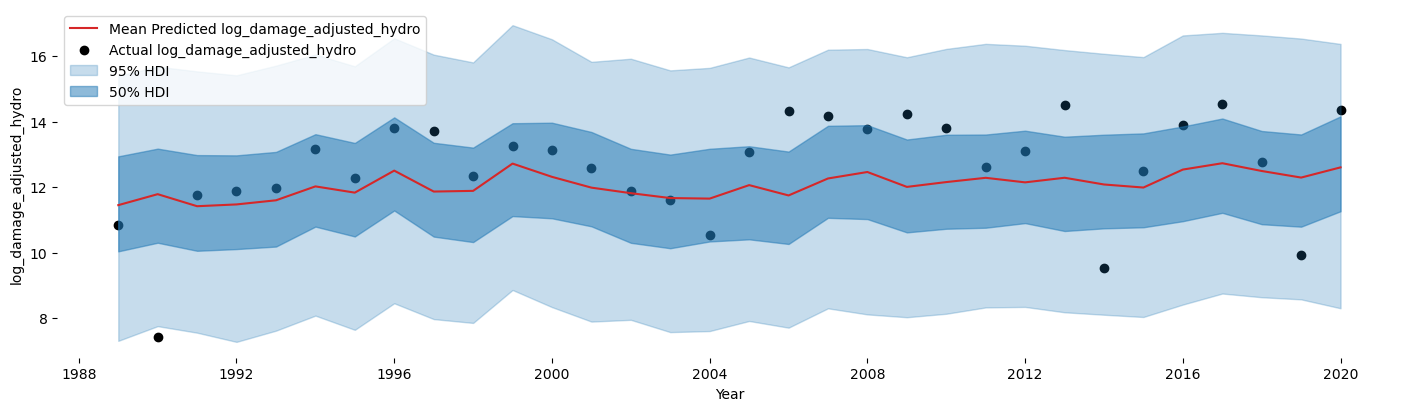

In [23]:
plotting_function(idata =simple_damages_idata , 
                  country = "VNM",
                  df = df_2 ,
                 target_variable= "log_damage_adjusted_hydro")

# Disaster predictions

In [24]:
import pytensor
#Redefine add data
def add_data(features: list[str], df: pd.DataFrame, add_time :bool = False, target: str | None = None, name = None, dims=None, dtype=None):
    X_name = 'X' if name is None else f'X_{name}'
    Y_name = 'Y' if name is None else f'Y_{name}'
    
    if dtype is None:
        dtype = pytensor.config.floatX
        
    with pm.modelcontext(None):
        X = pm.Data(X_name, df[features].astype(dtype), dims=dims)
        
        if target is not None:
            Y = pm.Data(Y_name, df[target].astype(dtype), dims=dims[0] if dims is not None else dims)
            return X, Y
        
    return X

In [25]:
#Define the used fd
#Delimiting data set
model_list_2 = ['ISO', 'Start_Year', "is_disaster", 'log_distance_to_river', 'log_distance_to_coastline',
                'is_island', "lat", "long" ]


distance_features_2 = ['log_distance_to_river', 'log_distance_to_coastline', 'is_island']

time_varying_features_2 = ["Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared']

model_df_2 = merged_df5[model_list_2 + time_varying_features_2].dropna()

In [26]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(model_df_2["is_disaster"])
ISO_idx, ISO = pd.factorize(model_df_2["ISO"]) 
obs_idx = model_df_2.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(model_df_2.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_2 = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "distance_features": distance_features_2,
        "time_varying_features" : time_varying_features_2,
        "gp_feature":gp_features }

In [27]:
#Define pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

pipeline = ColumnTransformer([('standardize', StandardScaler(), ['log_distance_to_river', 'log_distance_to_coastline'] + time_varying_features_2)],
                            remainder='passthrough')
model_data = pd.DataFrame(pipeline.fit_transform(model_df_2),
                          index=model_df_2.index,
                          columns=[x.split('__')[-1] for x in pipeline.get_feature_names_out()])

In [28]:
#Read idata 
floatX = pytensor.config.floatX
HSGP_full_model_idata = az.from_netcdf("../data/HSGP_full_model_idata.netcdf")

In [29]:
laos_grid_2d = np.array(laos_points[["lat", "lon"]])

In [30]:
laos_data_by_year = model_df_2.query('ISO == "LAO"')[time_varying_features_2 + ['Start_Year']].drop_duplicates().set_index('Start_Year').sort_index()

In [31]:
ref_year = '2020'
laos_idx = ISO.tolist().index('LAO')
laos_points = laos_points.assign(ISO = 'LAO', Start_Year = f'{ref_year}-01-01', is_disaster=0)
laos_points = laos_points.rename(columns={'lon':'long'})

laos_data_by_year.loc[f'{ref_year}-01-01']
for col in time_varying_features_2:
    laos_points[col] = laos_data_by_year.loc[f'{ref_year}-01-01', col].item()


In [32]:
laos_plot_data = pd.DataFrame(pipeline.transform(laos_points),
                              index=laos_points.index,
                              columns=[x.split('__')[-1] for x in pipeline.get_feature_names_out()])

In [33]:
def compute_center(X):
    return (pt.max(X, axis=0) + pt.min(X, axis=0)).eval() / 2

In [34]:
from copy import deepcopy
from pymc.model.transform.optimization import freeze_dims_and_data
plot_coords = deepcopy(coords_2)
plot_coords['obs_idx'] = np.arange(laos_plot_data.shape[0])

with pm.Model(coords=plot_coords) as HSGP_full_model_plot:
    geographic_data = add_data(features= distance_features_2 ,  target = None, df =  laos_plot_data, dims=['obs_idx', 'features'])
    economic_data = add_data(features = time_varying_features_2 ,  target = None, df =  laos_plot_data, name='time_varying', dims=['obs_idx', 'time_varying_features'])
    X_gp = pm.Data("X_gp", laos_plot_data[["lat", "long"]].astype(floatX), dims=['obs_idx', 'gp_feature'])

    #Country effect
    country_effect = pm.Flat("country_effect", dims = ["ISO"])    

    #Betas
    geographic_betas = pm.Flat("geographic_betas", dims = ["distance_features"])
    economic_betas = pm.Flat("economic_betas", dims = ["time_varying_features"])

    # Prior on the HSGP
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 20, 20, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    gp._X_center = compute_center(model_data[["lat", "long"]].astype(floatX))

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    HSGP_component = pm.Deterministic('HSGP_component', phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])
    geographic_component = pm.Deterministic('geographic_component', geographic_data @ geographic_betas, dims=['obs_idx'])
    economic_component = pm.Deterministic('economic_component', economic_data @ economic_betas, dims=['obs_idx'])
    
    logit_p = pm.Deterministic('logit_p', country_effect[laos_idx] + geographic_component + economic_component + HSGP_component, dims=['obs_idx'])
    p = pm.Deterministic('p', pm.math.invlogit(logit_p), dims=['obs_idx'])
    
    
with freeze_dims_and_data(HSGP_full_model_plot):
    idata_plot = pm.sample_posterior_predictive(HSGP_full_model_idata, extend_inferencedata=False, compile_kwargs={'mode':'JAX'},
                                                var_names=['HSGP_component', 'geographic_component', 'economic_component', 'logit_p', 'p'])

Sampling: []


Output()

In [35]:
#Store df of predictions
HSGP_full_model_predictions = idata_plot.posterior_predictive.mean(dim=("chain", "draw")).to_dataframe()

#Merge predictions with Laos points
HSGP_full_model_predictions = pd.merge(HSGP_full_model_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

#Transform into geo Data Frame
HSGP_full_model_predictions_geo = gpd.GeoDataFrame(
                HSGP_full_model_predictions,
    geometry=gpd.points_from_xy(HSGP_full_model_predictions["long"],
                                HSGP_full_model_predictions["lat"]),crs="EPSG:4326"
            )

In [36]:
# with HSGP_full_model:
#     pm.set_data({'X': laos_plot_data[distance_features_2].values.astype(float),
#                  'Y': np.zeros(laos_plot_data.shape[0]),
#                  'X_time_varying': laos_plot_data[time_varying_features_2].values.astype(float),
#                  'X_gp': laos_plot_data[['lat', 'long']].astype(float).values,
#                  'ISO_idx':np.full(laos_plot_data.shape[0], laos_idx)},
#                 coords={'obs_idx': laos_plot_data.index.values})
# with freeze_dims_and_data(HSGP_full_model):
#     idata_laos = pm.sample_posterior_predictive(HSGP_full_model_idata, extend_inferencedata=False, compile_kwargs={'mode':'JAX'})

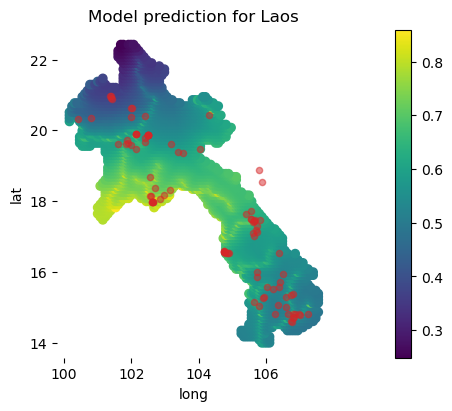

In [37]:
#Plot the predictions
fig, ax = plt.subplots()
HSGP_full_model_predictions_geo.plot("p",legend=True, ax=ax)
model_df_2.query('ISO == "LAO" & is_disaster == 1').plot.scatter(x='long', y='lat', ax=ax, c='tab:red', alpha=0.5)
plt.title("Model prediction for Laos", );

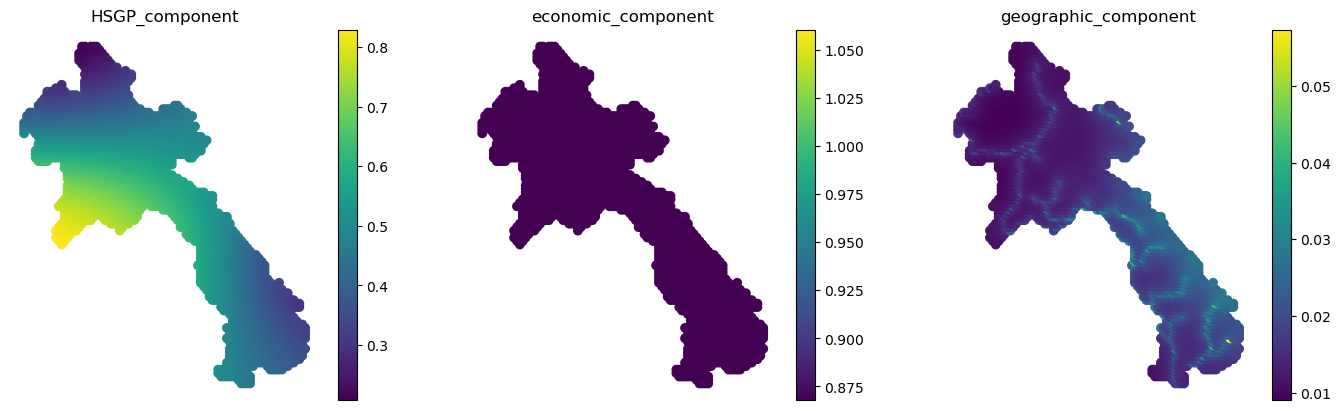

In [38]:
from scipy.special import expit
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for name, axis in zip(['HSGP_component', 'economic_component', 'geographic_component'], fig.axes):
    temp = expit(idata_plot.posterior_predictive[name]).mean(dim=['chain', 'draw']).to_dataframe()
    temp = pd.merge(temp, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

    #Transform into geo Data Frame
    temp = gpd.GeoDataFrame(
                    temp,
        geometry=gpd.points_from_xy(HSGP_full_model_predictions["long"],
                                    HSGP_full_model_predictions["lat"]),crs="EPSG:4326"
                )
    temp.plot(name, legend=True, ax=axis)
    axis.set_title(name)
    axis.axis('off')
plt.show()

### Point predictions

In [39]:
#Prepare point for predictions

points_df = pd.DataFrame(index = [1])

#Indicate Capital coords
points_df.loc[1, "lat"] = 17.97570560
points_df.loc[1, "long"] = 102.63310350



points_df_geo =  gpd.GeoDataFrame(
                points_df, geometry=gpd.points_from_xy(points_df["long"], points_df["lat"]), crs="EPSG:4326"
            )


#Get distances
log_point_distance_rivers = np.log(get_distance_to(rivers.boundary, points=points_df_geo, return_columns=None)
                              .rename(columns={'distance_to_closest':'log_distance_to_river'}))

log_point_distance_coastlines  = np.log(get_distance_to(coastline.boundary, points=points_df_geo, return_columns=None)
                              .rename(columns={'distance_to_closest':'log_distance_to_coastline'}))

#standardize distances
log_point_distance_rivers_stand = (log_point_distance_rivers - model_df_2['log_distance_to_river'].mean()) /model_df_2['log_distance_to_river'].std()

log_point_distance_coastlines_stand = (log_point_distance_coastlines - model_df_2['log_distance_to_coastline'].mean()) /model_df_2['log_distance_to_coastline'].std()

point_distance_data =  pd.merge(log_point_distance_rivers_stand, log_point_distance_coastlines_stand, left_index=True, right_index= True, how= "inner")

point_distance_data.loc[1, "is_island"] = False

point_distance_data.rename(columns = { "log_distance_to_river": "log_distance_to_river",
                                     })

point_time_varying_data = laos_plot_data[time_varying_features_2].loc[[0]]

#merge point data
final_point_df =  pd.concat([points_df_geo, point_distance_data], axis =1 ).reset_index()

final_point_df = pd.concat([point_time_varying_data, final_point_df] , axis =1 )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
#Create the new 0 point to avoid the bug

cols = ['Population', 'co2', 'precip_deviation', 'dev_ocean_temp',
       'log_population_density', 'log_population_density_squared',
       'log_gdp_per_cap', 'log_gdp_per_cap_squared', 'index', 'lat',
       'long', 'log_distance_to_river',
       'log_distance_to_coastline', 'is_island']

for x in cols:
    final_point_df.loc[1, x] = 0

In [41]:
#Define new coords
new_plot_coords = plot_coords.copy()

new_plot_coords["obs_idx"] = final_point_df.index.values

In [42]:
final_point_df

,Population,co2,precip_deviation,dev_ocean_temp,log_population_density,log_population_density_squared,log_gdp_per_cap,log_gdp_per_cap_squared,index,lat,long,geometry,log_distance_to_river,log_distance_to_coastline,is_island
0,-0.438117,1.630052,-0.923467,-0.644767,0.125562,0.125562,-0.544221,-0.544221,1.0,17.975706,102.633104,POINT (102.6331 17.97571),2.475182,3.850443,False
1,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,None,0.000000,0.000000,0


In [43]:
#Point prediction
from copy import deepcopy
from pymc.model.transform.optimization import freeze_dims_and_data
plot_coords = deepcopy(coords_2)
plot_coords['obs_idx'] = np.arange(laos_plot_data.shape[0])

with pm.Model(coords=new_plot_coords) as HSGP_full_model_plot:
    geographic_data = add_data(features= distance_features_2 ,  target = None, df =  final_point_df, dims=['obs_idx', 'features'])
    economic_data = add_data(features = time_varying_features_2 ,  target = None, df =  final_point_df, name='time_varying', dims=['obs_idx', 'time_varying_features'])
    X_gp = pm.Data("X_gp", final_point_df[["lat", "long"]].astype(floatX), dims=['obs_idx', 'gp_feature'])

    #Country effect
    country_effect = pm.Flat("country_effect", dims = ["ISO"])    

    #Betas
    geographic_betas = pm.Flat("geographic_betas", dims = ["distance_features"])
    economic_betas = pm.Flat("economic_betas", dims = ["time_varying_features"])

    # Prior on the HSGP
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 20, 20, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    gp._X_center = compute_center(model_data[["lat", "long"]].astype(floatX))

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    HSGP_component = pm.Deterministic('HSGP_component', phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])
    geographic_component = pm.Deterministic('geographic_component', geographic_data @ geographic_betas, dims=['obs_idx'])
    economic_component = pm.Deterministic('economic_component', economic_data @ economic_betas, dims=['obs_idx'])
    
    logit_p = pm.Deterministic('logit_p', country_effect[laos_idx] + geographic_component + economic_component + HSGP_component, dims=['obs_idx'])
    p = pm.Deterministic('p', pm.math.invlogit(logit_p), dims=['obs_idx'])
    
    
with freeze_dims_and_data(HSGP_full_model_plot):
    idata_plot_point = pm.sample_posterior_predictive(HSGP_full_model_idata, extend_inferencedata=False, compile_kwargs={'mode':'JAX'},
                                                var_names=['HSGP_component', 'geographic_component', 'economic_component', 'logit_p', 'p'])

Sampling: []


Output()

In [44]:
#Store df of predictions
HSGP_point_predictions = idata_plot_point.posterior_predictive.mean(dim=("chain", "draw")).to_dataframe()

#Merge predictions with Laos points
HSGP_point_predictions = pd.merge(HSGP_point_predictions, laos_points, 
                                       left_index=True, right_index=True,
                                       how = "left")

HSGP_point_predictions = HSGP_point_predictions.loc[[0]]

In [45]:
HSGP_point_predictions.loc[0]

HSGP_component                                                        3.434724
economic_component                                                    3.304636
geographic_component                                                 -4.112682
logit_p                                                               3.883981
p                                                                     0.805715
Unnamed: 0                                                                   0
geometry                          POINT (105.88057796723237 13.99668675655562)
long                                                                105.880578
lat                                                                  13.996687
distance_to_river                                                  3058.702956
ORD_FLOW                                                                     3
HYRIV_ID                                                              41330520
distance_to_coastline                               